In [2]:
import torch
import random
import numpy as np
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 14})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 14})

plt.rcParams.update({'axes.grid': False})
%matplotlib inline

from mfact import kpmf

In [4]:
class SEKernel(nn.Module):
    
    def __init__(self, ell=1.0, sigma=1.0):
        super(SEKernel, self).__init__()
        self.ell = Parameter(torch.Tensor([ell]))
        self.sigma = Parameter(torch.Tensor([sigma]))
        
    def forward(self, X1, X2, inds=None):
        A = torch.sum(X1 ** 2, dim=1, keepdim=True)
        B = torch.sum(X2 ** 2, dim=1, keepdim=True)
        B = torch.t(B)
        C = 2 * torch.matmul(X1, torch.t(X2))
        D = A + B - C
        return self.sigma ** 2 * torch.exp(-0.5 * D / self.ell ** 2)  

In [ ]:
# Initialize U and V from GP prior, or just randomly?
# Is it a good idea to vary the kernel hyperparameters and sigma along with U and V?
# Save kernel calculations?
# SGD vs GD?
# Works even if entire row or column is missing?

In [346]:
class FactorModel(nn.Module):

    def __init__(self, n_rows, n_cols, rank):
        super(FactorModel, self).__init__()
        self.rank = rank
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.U = nn.Embedding(self.n_rows, rank)
        self.V = nn.Embedding(self.n_cols, rank)
        stdv = torch.rsqrt(torch.Tensor([self.rank]))[0]
        self.U._parameters['weight'].data.uniform_(-stdv, stdv)
        self.V._parameters['weight'].data.uniform_(-stdv, stdv)


    def forward(self, row_ids, col_ids):
        rows = self.U(row_ids)
        cols = self.V(col_ids)
        return torch.sum(rows * cols, dim=2).squeeze()

    
class KPMFLoss(nn.Module):
    
    def __init__(self, sigma, K_U, K_V):
        super(KPMFLoss, self).__init__()
        self.K_U = K_U
        self.K_V = K_V
        self.S_U = K_U.inverse()
        self.S_V = K_V.inverse()
        self.sigma = Parameter(torch.Tensor([sigma]))
        
    def forward(self, preds, targets, U, V):
        se = torch.sum((preds - targets) ** 2)
        se = se / self.sigma ** 2 / 2.0
        U_loss = U.t() @ self.S_U
        U_loss = 0.5 * torch.sum(U_loss * U.t())
        V_loss = V.t() @ self.S_V 
        V_loss = 0.5 * torch.sum(V_loss * V.t())
        return se + U_loss + V_loss
    
    
class KPMF(object):
    
    def __init__(self, rank, K_U, K_V, sigma=0.1, lr=0.1):
        super(KPMF, self).__init__()
        n_rows = K_U.size()[0]
        n_cols = K_V.size()[0]
        self.lr = lr
        self.model = FactorModel(n_rows, n_cols, rank)
        self.loss_function = KPMFLoss(sigma, K_U, K_V)
        self.U_optimizer = torch.optim.SGD([self.model.U._parameters['weight']], lr=lr)
        self.V_optimizer = torch.optim.SGD([self.model.V._parameters['weight']], lr=lr)
        
    def predict(self, rows, cols):
        return self.model(rows, cols)
    
    def RMSE(self, rows, cols, targets):
        preds = self.predict(rows, cols)
        n = len(rows)
        return torch.sqrt(torch.sum((preds - targets) ** 2) / n)
    
    def fit(self, train_data, val_data, batch_size, min_its, max_its, early=True):
        self.history = {
            'loss': [],
            'train_SE': [],
            'valid_SE': []
        }
        rows_t, cols_t, tars_t = train_data
        rows_v, cols_v, tars_v = val_data
        n = len(tars_t)
        inds = np.arange(n)
        batches = int(np.ceil(n / batch_size))
        
        for it in range(max_its):
            np.random.shuffle(inds)
            total_loss = 0
            for idx in range(batches):
                if idx == batches - 1:
                    batch_idxs = inds[idx * batch_size:]
                else:
                    batch_idxs = inds[idx * batch_size: (idx + 1) * batch_size]
                batch_idxs = torch.LongTensor(batch_idxs)
                rows_b = rows_t[batch_idxs]
                cols_b = cols_t[batch_idxs]
                tars_b = tars_t[batch_idxs]
                loss = self.train_batch((rows_b, cols_b, tars_b))
                total_loss += loss.data.numpy()[0]
            self.history['loss'].append(total_loss / batches)
            self.history['train_SE'].append(
                self.RMSE(rows_t, cols_t, tars_t).data.numpy()[0])
            self.history['valid_SE'].append(
                self.RMSE(rows_v, cols_v, tars_v).data.numpy()[0])

            print('\rIteration %d\tloss = %.4f\ttrain SE = %.3f\tvalid SE = %.3f'
                  %(it+1, self.history['loss'][-1], self.history['train_SE'][-1],
                    self.history['valid_SE'][-1]),
                 end='')
            if early:
                if it > min_its:
                    if self.history['valid_SE'][-1] > self.history['valid_SE'][-2]:
                        print('\nTerminating based on validation')
                        break
        return self.history
    
    def train_batch(self, train_data):
        rows, cols, targets = train_data
        self.U_optimizer.zero_grad()
        preds = self.model(rows, cols)
        L = self.loss_function(preds, targets, self.model.U._parameters['weight'], 
                      self.model.V._parameters['weight'])
        L.backward(retain_graph=True)
        self.U_optimizer.step()
        self.V_optimizer.zero_grad()
        preds = self.model(rows, cols)
        L = self.loss_function(preds, targets, self.model.U._parameters['weight'], 
                      self.model.V._parameters['weight'])
        self.V_optimizer.step()
        return L
        


np.random.seed(1)
n_rows = 300
n_cols = 20
rank_actual = 2
n_per = 80
row_info = np.random.random((n_rows, rank_actual))
col_info = np.random.random((n_cols, rank_actual))
row_info = Variable(torch.Tensor(row_info))
col_info = Variable(torch.Tensor(col_info))
k = SEKernel()
K_U = k(row_info, row_info)
K_V = k(col_info, col_info)
U_actual = np.array(
    [np.random.multivariate_normal(np.zeros(n_rows), K_U.data.numpy()) 
     for _ in range(rank_actual)]).T
V_actual = np.array(
    [np.random.multivariate_normal(np.zeros(n_cols), K_V.data.numpy()) 
     for _ in range(rank_actual)])
Y = U_actual @ V_actual

rids = Variable(torch.LongTensor([[0, 2, 0, 5]])).t()
cids = Variable(torch.LongTensor([[1, 3, 3, 2]])).t()
ids_numpy = np.concatenate((rids.data.numpy(), cids.data.numpy()), axis=1)
targets = Variable(torch.Tensor(Y[ids_numpy[:, 0], ids_numpy[:, 1]]))

np.mean(Y), np.std(Y)

/Users/kevinyang/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:135: RuntimeWarning: covariance is not positive-semidefinite.
/Users/kevinyang/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: covariance is not positive-semidefinite.


(-2.1565073623669164, 0.63913957806549493)

In [355]:
np.random.seed(0)

k = SEKernel(ell=1.0)
K_U = k(row_info, row_info)
K_V = k(col_info, col_info)

all_inds = [(i, j) for i in range(n_rows) for j in range(n_cols)]
chosen = [np.random.choice(np.arange(n_rows), size=n_per, replace=False) 
          for _ in range(n_cols)]
target_inds = [(i, j) for j, chose in enumerate(chosen) for i in chose]
train_inds = random.sample(target_inds, int(0.8 * n_per * n_cols))
val_inds = [ind for ind in target_inds if ind not in train_inds]
test_inds = [ind for ind in all_inds if ind not in target_inds]

r_train = np.array([[inds[0]] for inds in train_inds])
r_train = Variable(torch.LongTensor(r_train))
c_train = np.array([[inds[1]] for inds in train_inds])
c_train = Variable(torch.LongTensor(c_train))
y_train = Variable(torch.Tensor([Y[inds[0], inds[1]] for inds in train_inds]))
train_data = (r_train, c_train, y_train)

y_val = Variable(torch.Tensor([Y[inds[0], inds[1]] for inds in val_inds]))
r_val = np.array([[inds[0]] for inds in val_inds])
r_val = Variable(torch.LongTensor(r_val))
c_val = np.array([[inds[1]] for inds in val_inds])
c_val = Variable(torch.LongTensor(c_val))
val_data = (r_val, c_val, y_val)

y_test = Variable(torch.Tensor([Y[inds[0], inds[1]] for inds in test_inds]))
r_test = np.array([[inds[0]] for inds in test_inds])
r_test = Variable(torch.LongTensor(r_test))
c_test = np.array([[inds[1]] for inds in test_inds])
c_test = Variable(torch.LongTensor(c_test))
test_data = (r_test, c_test, y_test)

rank = 25
clf = KPMF(rank, K_U, K_V, sigma=0.000005, lr=1e-13)
history = clf.fit(train_data, val_data, 128, 100, 5000, early=True)

Iteration 149	loss = 8829922338406.4004	train SE = 1.858	valid SE = 2.212
Terminating based on validation


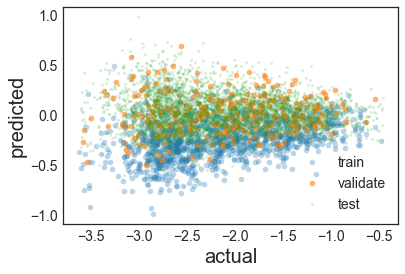

In [352]:
### pal = sns.color_palette()



_ = plt.plot(y_train.data.numpy(), 
             clf.model(r_train, c_train).data.numpy(), 'o', alpha=0.3, label='train')
_ = plt.plot(y_val.data.numpy(),
             clf.model(r_val, c_val).data.numpy(), 'o', alpha=0.6, label='validate')
_ = plt.plot(y_test.data.numpy(), 
             clf.model(r_test, c_test).data.numpy(), '.', alpha=0.2, label='test')

# _ = plt.gca().set_aspect('equal', adjustable='box')
_ = plt.legend()
_ = plt.xlabel('actual')
_ = plt.ylabel('predicted')

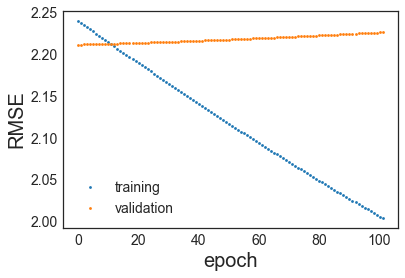

In [353]:
_ = plt.plot(history['train_SE'][-300:], '.', label='training')
_ = plt.plot(history['valid_SE'][-300:], '.', label='validation')
_ = plt.legend()
_ = plt.xlabel('epoch')
_ = plt.ylabel('RMSE')

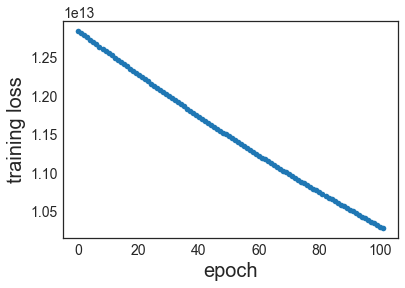

In [354]:
_ = plt.plot(history['loss'], 'o')
_ = plt.xlabel('epoch')
_ = plt.ylabel('training loss')